In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from basketball_reference_scraper.shot_charts import get_shot_chart
from basketball_reference_scraper.players import get_stats, get_game_logs
from pydotplus import graph_from_dot_data
from IPython.display import Image
from datetime import datetime, timedelta

In [2]:
rand_state = 23
np.random.seed(rand_state)

In [3]:
%matplotlib inline

In [4]:
def get_today():
    return datetime.now().date().strftime('%Y-%m-%d')

def time_to_secs(time_remaining):
    min_sec_split = time_remaining.split(':')
    time_in_quarter = float(min_sec_split[0])*60 + float(min_sec_split[1])
    return time_in_quarter

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "lr={:.3f}, probability={:.3f}%".format(xmax, ymax*100)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    
def extract_features(player, start, end, split=0.75, playoffs=False):
    df = get_game_logs(player, start, end, playoffs=playoffs, ask_matches=False)

    gp_dates = list(df['DATE'].astype(str))
    gp_teams = list(df['TEAM'])
    gp_opponents = list(df['OPPONENT'])

    gp = len(gp_dates)

    print(f'Found shot data for {gp} games played by {player}.')

    shots_aggregate = np.zeros((0,7))

    for idx in range(gp):
        s = get_shot_chart(gp_dates[idx], gp_teams[idx], gp_opponents[idx])[gp_teams[idx]]
        ss = s.loc[(s['PLAYER'] == player)]

        fg_count = len(ss)
        shots = np.zeros((fg_count,7))
        for i in range(len(ss)):
            shots[i][0] = float(ss.iloc[i]['x'].strip(' ft'))
            shots[i][1] = float(ss.iloc[i]['y'].strip(' ft'))
            shots[i][2] = float(ss.iloc[i]['DISTANCE'].strip(' ft'))
            shots[i][3] = time_to_secs( ss.iloc[i]['TIME_REMAINING'] )
            shots[i][4] = 1 if ss.iloc[i]['QUARTER'] % 2 == 0 else 0 # 2nd or 4th quarter "end of half"
            shots[i][5] = 1 if ss.iloc[i]['QUARTER'] % 4 == 0 else 0 # 4th quarter "end of regulation"
            shots[i][6] = 1 if ss.iloc[i]['MAKE_MISS'] == 'MAKE' else 0 

        shots_aggregate = np.concatenate((shots_aggregate,shots), axis=0)
        
        if (idx % 100 == 0) and idx > 0:
            print(f'Data retrieved for {idx} games')
        elif idx == gp-1:
            print(f'All shot data retrieved for {gp} games')
            
    np.random.shuffle(shots_aggregate)
    
    train_range = math.floor(split * gp)


    X_train = shots_aggregate[:train_range,:-1]
    y_train = shots_aggregate[:train_range,-1:].ravel()

    X_test = shots_aggregate[train_range:,:-1]
    y_test = shots_aggregate[train_range:,-1:].ravel()

    return X_train, y_train, X_test, y_test

def percentile_analysis(clf, X_test, percentile):
    high_chance_buckets = np.zeros((0,7))

    for attempt in range(len(X_test)):
        prediction = clf.predict_proba(X_test[attempt].reshape(1,-1))

        if prediction[0][1] > percentile and prediction[0][1] < 0.999:
            high_chance_buckets = np.concatenate((high_chance_buckets, 
                                                  np.append(X_test[attempt],prediction[0][1]).reshape(1,-1)))

    return high_chance_buckets

def plot_percentile_shooting(player, high_chance_buckets, percentile):
    _max_time = np.max(high_chance_buckets[:,3])
    _min_time = np.min(high_chance_buckets[:,2])
    
    max_time = str(timedelta(seconds=_max_time))
    min_time = str(timedelta(seconds=_min_time))
    
    print(f'{player} should attemp a shot between {max_time} and {min_time}')
    
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['savefig.dpi'] = 150

    xlim = 50 # width of NBA court
    ylim = 47 # half the length of NBA court

    datafile = 'nbahalfcourt.png'
    img = plt.imread(datafile)
    img2 = np.flipud(img)
    
    colors = ["blue", "orange"]
    colormap = ListedColormap(colors)
    
    fourth_qt = np.argwhere(high_chance_buckets[:,-1]) # find all 4th quarter shots
    color_indices = np.zeros((high_chance_buckets.shape[0],1)) 
    color_indices[fourth_qt] = 1 # color code 4th quarter shots as red
    
    plt.scatter(1+high_chance_buckets[:,0],1+high_chance_buckets[:,1],zorder=1,
               c=color_indices, cmap=colormap)
    
    plt.title(f'{100*percentile}-percentile shooting by {player}')

    plt.imshow(img2, zorder=0, extent=[0, xlim,0, ylim])
    plt.xlim(0,xlim)
    plt.ylim(0,ylim)
    plt.figure(figsize=(12,8), dpi= 200, facecolor='w', edgecolor='k')

    plt.pause(0.0001)
    plt.show()
    
def fit_clt(X_train, y_train, X_test, y_test, plot=False):
    # Learning Rate Analysis 

    learning_rates = np.array(range(5, 50, 5))/500
    estimators = np.array(range(0, 1000, 250)[1:])

    plt_scores = np.zeros((0,3))

    clf_main = None
    clf_accuracy = 0.0

#     for n_estimators in estimators:
    for lr in learning_rates:
        n_estimators = 1000
        clf = GradientBoostingClassifier(n_estimators=n_estimators, 
                                         max_depth=10,
                                         learning_rate=lr, 
                                         criterion='squared_error',
                                         random_state=rand_state)
        clf.fit(X_train, y_train)
        score = accuracy_score(y_test, clf.predict(X_test))

        if score > clf_accuracy:
            clf_main = clf
            clf_accuracy = score
            print(f'Accuracy: {score*100:.2f}%, learning rate = {lr}, n_trees = {n_estimators} [New peak]')
        else:
#             print(f'Accuracy: {score*100:.2f}%, learning rate = {lr}, n_trees = {n_estimators}')
            pass


        results = np.array([score, lr, n_estimators]).reshape(1,-1)  
        plt_scores = np.concatenate((plt_scores, results),axis=0)

        #  Uncomment below to generate plots of the learning rate vs. accuracy
#     if plot:
#         # Plot learning rate vs. test accuracy
#         xmax = plt_scores[np.argmax(plt_scores[:,0])][1]
#         ymax = plt_scores[np.argmax(plt_scores[:,0])][0]

#         fig = plt.figure()
#         ax = plt.axes()
#         annot_max(plt_scores[:,1], plt_scores[:,0])
#         ax.set_ylim(0.5,.6)
#         plt.pause(0.0001)
#         plt.plot(plt_scores[:,1], plt_scores[:,0])
    
    return clf_main

def get_buckets(player, start='1996-11-01', end=get_today(), percentile=0.70, playoffs=False, plot=True):
    
    X_train, y_train, X_test, y_test = extract_features(player, start, end, split=0.75, playoffs=playoffs)
    clf = fit_clt(X_train, y_train, X_test, y_test, plot=plot)
    
    high_chance_buckets = percentile_analysis(clf=clf, X_test=X_test, percentile=percentile)
    
    return {'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test, 
            'percentile':percentile, 'buckets':high_chance_buckets, 'name':player, 'classifier':clf}

2012 shooting
Found shot data for 70 games played by Chris Paul.
All shot data retrieved for 70 games
Accuracy: 55.14%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 55.26%, learning rate = 0.03, n_trees = 1000 [New peak]
Accuracy: 55.89%, learning rate = 0.04, n_trees = 1000 [New peak]
Chris Paul should attemp a shot between 0:10:56 and 0:00:00


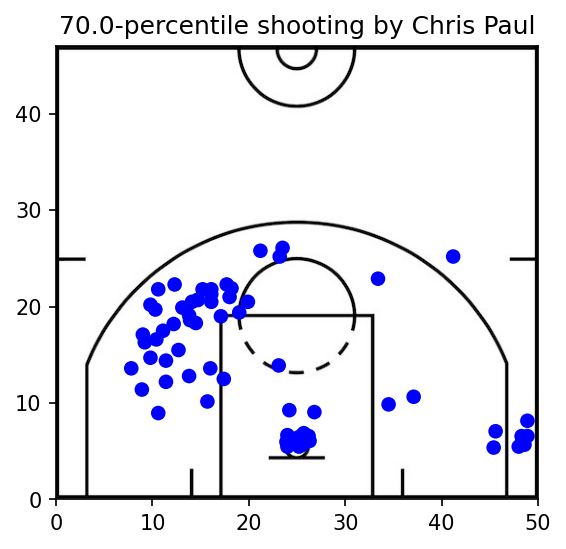

<Figure size 2400x1600 with 0 Axes>

Found shot data for 82 games played by Russell Westbrook.
All shot data retrieved for 82 games
Accuracy: 53.27%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 53.34%, learning rate = 0.07, n_trees = 1000 [New peak]
Accuracy: 53.96%, learning rate = 0.08, n_trees = 1000 [New peak]
Russell Westbrook should attemp a shot between 0:09:52 and 0:00:00


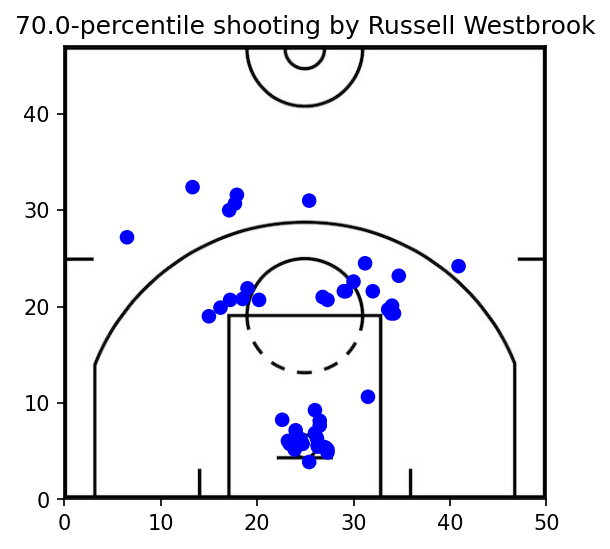

<Figure size 2400x1600 with 0 Axes>

Found shot data for 0 games played by Derrick Rose.
Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required.
Removing Derrick Rose...
Found shot data for 69 games played by Tim Duncan.
All shot data retrieved for 69 games
Accuracy: 55.91%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 56.24%, learning rate = 0.02, n_trees = 1000 [New peak]
Accuracy: 56.78%, learning rate = 0.06, n_trees = 1000 [New peak]
Tim Duncan should attemp a shot between 0:11:44 and 0:00:02


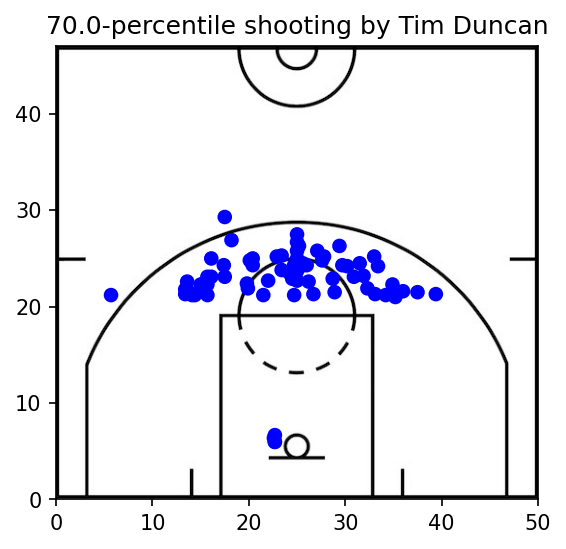

<Figure size 2400x1600 with 0 Axes>

Found shot data for 47 games played by Dirk Nowitzki.
All shot data retrieved for 47 games
Accuracy: 53.09%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 53.41%, learning rate = 0.03, n_trees = 1000 [New peak]
Dirk Nowitzki should attemp a shot between 0:01:58 and 0:00:13


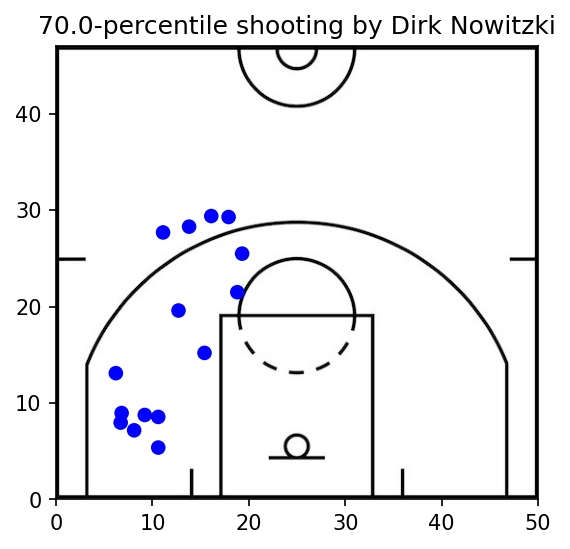

<Figure size 2400x1600 with 0 Axes>

Found shot data for 67 games played by Carmelo Anthony.
All shot data retrieved for 67 games
Accuracy: 55.35%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 55.42%, learning rate = 0.02, n_trees = 1000 [New peak]
Carmelo Anthony should attemp a shot between 0:10:58 and 0:00:01


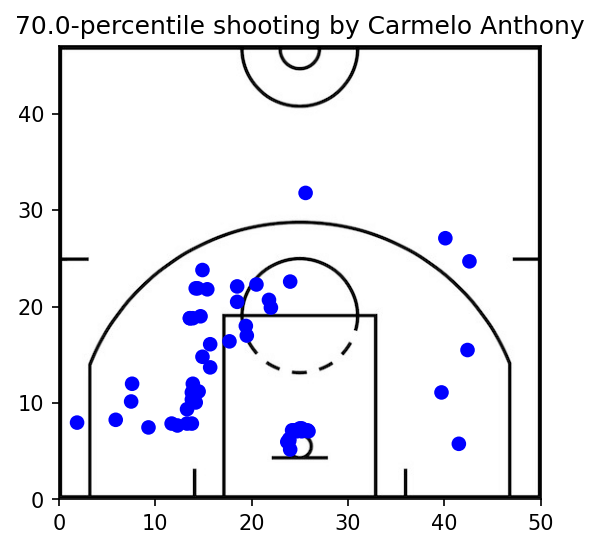

<Figure size 2400x1600 with 0 Axes>

Found shot data for 79 games played by Paul George.
All shot data retrieved for 79 games
Accuracy: 51.36%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 51.99%, learning rate = 0.02, n_trees = 1000 [New peak]
Accuracy: 52.17%, learning rate = 0.06, n_trees = 1000 [New peak]
Paul George should attemp a shot between 0:11:46 and 0:00:02


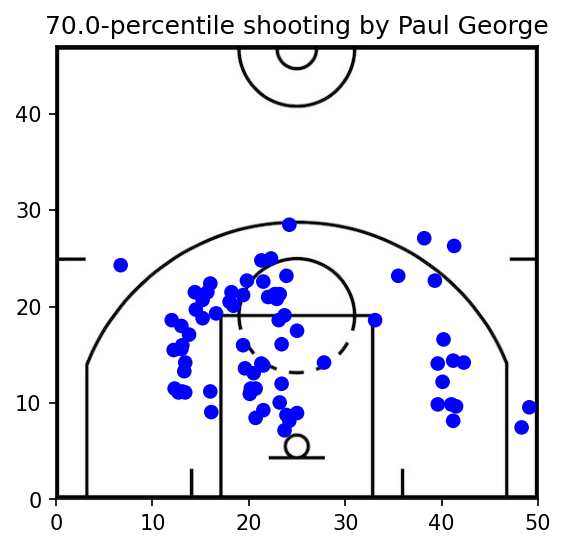

<Figure size 2400x1600 with 0 Axes>

Found shot data for 76 games played by LeBron James.
All shot data retrieved for 76 games
Accuracy: 54.78%, learning rate = 0.01, n_trees = 1000 [New peak]
Accuracy: 55.56%, learning rate = 0.02, n_trees = 1000 [New peak]
LeBron James should attemp a shot between 0:11:34 and 0:00:00


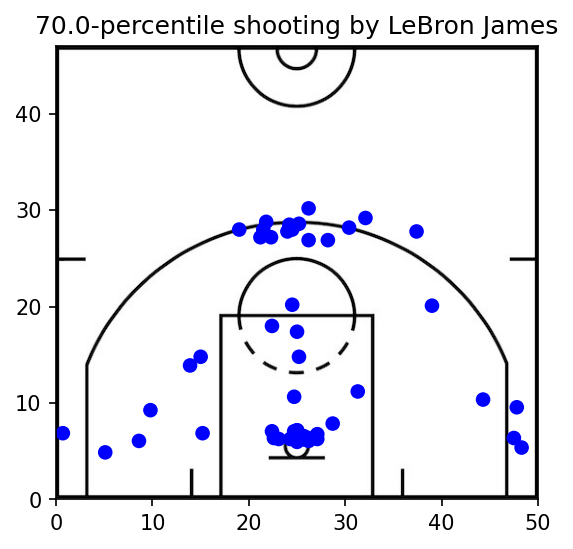

<Figure size 2400x1600 with 0 Axes>

In [5]:
players = [
    'Chris Paul',
    'Russell Westbrook', 
    'Derrick Rose',
    'Kawhi Leonard',
    'Tim Duncan',
    'Dirk Nowitzki',
    'Carmelo Anthony', 
    'Paul George', 
    'LeBron James' 
]

data = {}

start = '2012-10-30'
end = '2013-06-21'

print('2012 shooting')

for player in players:  
    try:
        data[player] = get_buckets(player, start=start, end=end, percentile=0.70, playoffs=False, plot=False)
        plot_percentile_shooting(data[player]['name'], data[player]['buckets'], data[player]['percentile'])
    except ValueError as ve:
        print(ve)
        print(f'Removing {player}...')
        players.remove(player)
        continue